# Loan Approval Prediction - Data Analysis & Model Training
## 1. Аналіз даних, препроцесинг, побудова моделі, візуалізації

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

In [2]:
# 1.1 Завантаження даних
df = pd.read_csv('loan_data.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


In [3]:
# 1.2 Аналіз пропусків
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            381 non-null    object 
 1   Gender             376 non-null    object 
 2   Married            381 non-null    object 
 3   Dependents         373 non-null    object 
 4   Education          381 non-null    object 
 5   Self_Employed      360 non-null    object 
 6   ApplicantIncome    381 non-null    int64  
 7   CoapplicantIncome  381 non-null    float64
 8   LoanAmount         381 non-null    float64
 9   Loan_Amount_Term   370 non-null    float64
 10  Credit_History     351 non-null    float64
 11  Property_Area      381 non-null    object 
 12  Loan_Status        381 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 38.8+ KB


Loan_ID               0
Gender                5
Married               0
Dependents            8
Education             0
Self_Employed        21
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     11
Credit_History       30
Property_Area         0
Loan_Status           0
dtype: int64

In [4]:
# 1.3 Аналіз категоріальних та числових ознак
cat_cols = df.select_dtypes(include='object').columns.tolist()
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
print('Категоріальні:', cat_cols)
print('Числові:', num_cols)

Категоріальні: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']
Числові: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


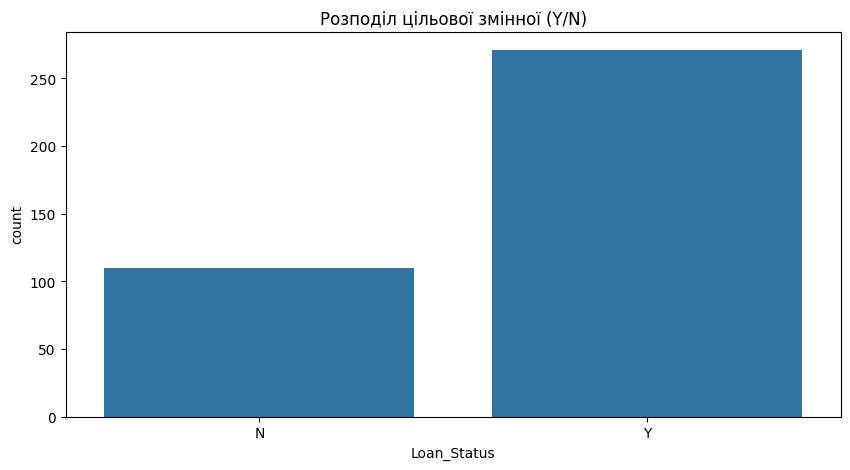

In [5]:
# 1.4 Візуалізація розподілів
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='Loan_Status')
plt.title('Розподіл цільової змінної (Y/N)')
plt.savefig('../predictor/static/predictor/plots/loan_status_dist.png')
plt.show()

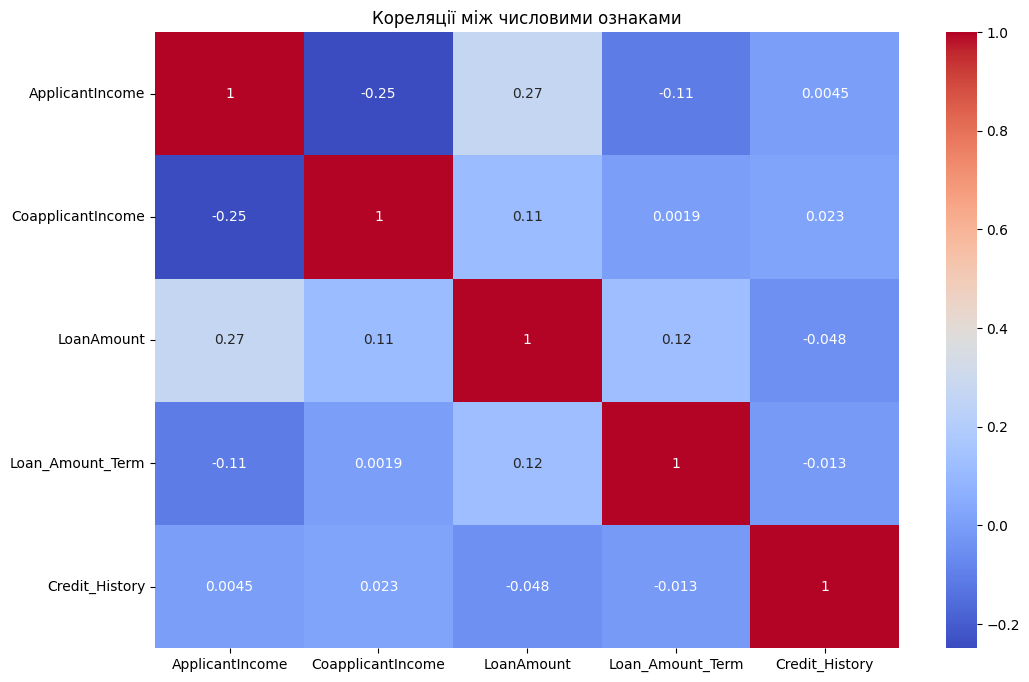

In [6]:
# 1.5 Кореляційна матриця
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Кореляції між числовими ознаками')
plt.savefig('../predictor/static/predictor/plots/corr_heatmap.png')
plt.show()

In [7]:
# 1.6 Препроцесинг
X = df.drop(['Loan_ID', 'Loan_Status'], axis=1)
y = df['Loan_Status'].map({'Y':1, 'N':0})
# Категоріальні ознаки
categorical = X.select_dtypes(include='object').columns.tolist()
numerical = X.select_dtypes(include=['int64','float64']).columns.tolist()

# Для ordinal залежностей (Dependents)
ordinal_cols = ['Dependents']
ordinal_map = [['0', '1', '2', '3+']]

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())]), numerical),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))]),
     [col for col in categorical if col not in ordinal_cols]),
    ('ord', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder(categories=ordinal_map))]), ordinal_cols)
])

In [8]:
# 1.7 Pipeline + RandomForest
pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])

In [9]:
# 1.8 GridSearchCV
param_grid = {
    'clf__n_estimators':[100, 200],
    'clf__max_depth':[None, 6, 10],
    'clf__min_samples_split':[2, 5]
}

gs = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
gs.fit(X, y)
print('Best params:', gs.best_params_)
print('Best score:', gs.best_score_)

# Зберегти модель
joblib.dump(gs.best_estimator_, 'loan_model.pkl')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'clf__max_depth': 6, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Best score: 0.8425153793574847


['loan_model.pkl']

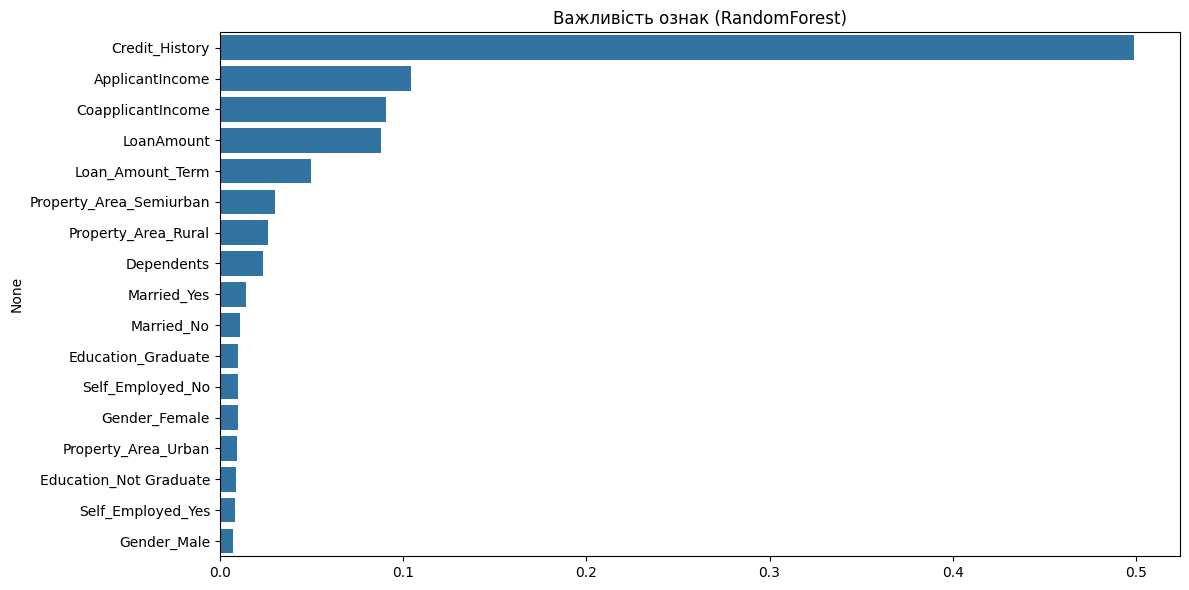

In [10]:
# 1.9 Важливість ознак
best_model = gs.best_estimator_.named_steps['clf']
feature_names = (
    numerical +
    list(gs.best_estimator_.named_steps['pre'].transformers_[1][1].named_steps['encoder'].get_feature_names_out([col for col in categorical if col not in ordinal_cols])) +
    ordinal_cols
)
importances = best_model.feature_importances_
feat_imp = pd.Series(importances, index=feature_names)
feat_imp = feat_imp.sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title('Важливість ознак (RandomForest)')
plt.tight_layout()
plt.savefig('../predictor/static/predictor/plots/feature_importance.png')
plt.show()